# **scNET: Learning Context-Specific Gene and Cell Embeddings by Integrating Single-Cell Gene Expression Data with Protein-Protein Interaction Information**

### In this notebook, we demonstrate how to apply scNET to larger datasets.  
To reduce training time, we subsample cells during training and then apply the trained model to the remaining cells.


**Install scnet using pip**

**It may be necessary to restart (not delete) the runtime after installing scNET in Google Colab. We are working on fixing this issue in future releases.**

This is still a beta version, so please install scNET from TestPyPI.
---



In [ ]:
#!pip install scnet

! pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple  scnet==0.2.4.1

!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


**Download data**

In [1]:
import gdown
download_url = f'https://drive.google.com/uc?id=1g257SA-SKFODfs8TwiVkhe99JKnnb1RJ'
output_path = './adata.h5ad'
gdown.download(download_url, output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1g257SA-SKFODfs8TwiVkhe99JKnnb1RJ
From (redirected): https://drive.google.com/uc?id=1g257SA-SKFODfs8TwiVkhe99JKnnb1RJ&confirm=t&uuid=5efd6711-5395-4e81-b794-cf389bc26358
To: /content/adata.h5ad
100%|██████████| 1.04G/1.04G [00:18<00:00, 56.1MB/s]


'./adata.h5ad'

### For subsampled training, pass `subsample_size` to the `run_scNET` function.  
A subsample of 10,000 - 15,000 cells is typically ideal.


In [ ]:
import scanpy as sc
import scNET
#consider higher number of de genes for larger datasets
scNET.main.DE_GENES_NUM = 10000
obj = sc.read_h5ad("./adata.h5ad")
obj.var.index = obj.var.feature_name.apply(lambda x: x.split("_")[0]).values
obj.var_names_make_unique()
sc.pp.normalize_total(obj, target_sum=1e4)
sc.pp.log1p(obj)
obj.raw = obj.copy()

scNET.run_scNET(obj, pre_processing_flag=False, human_flag=True, number_of_batches=10, split_cells=True, save_model_flag=True, max_epoch=350, model_name = "cellXgene", subsample_size=15000)


/home/bnet/ronsheinin/anaconda3/envs/spNET/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/bnet/ronsheinin/anaconda3/envs/spNET/lib/python3.10/site-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/bnet/ronsheinin/anaconda3/envs/spNET/lib/python3.10/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/bnet/ronsheinin/anaconda3/envs/spNET/lib/python3.10/site-packages/torch_spline_conv/_basis_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(
/home/bnet/ronsheinin/anaconda3/envs/spNET/lib/python3.10/site-packages/torch_geometric/typing.py:124: UserWarning: An 

Building k-NN graph with 25 neighbors


Training: 100%|██████████| 350/350 [1:38:42<00:00, 16.92s/it, Row Loss=0.8359, Col Loss=1.5779]


Best Network AUC: 0.8939813738064408


scNET(
  (encoder): MutualEncoder(
    (rows_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0) - SAGEConv(1500, 1500, aggr=mean): x, edge_index -> x1
        (1) - Dropout(p=0.25, inplace=False): x1 -> x2
        (2) - LeakyReLU(negative_slope=0.01, inplace=True): x2 -> x2
      )
    )
    (cols_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0) - SAGEConv(13768, 13768, aggr=mean): x, edge_index -> x1
        (1) - LeakyReLU(negative_slope=0.01, inplace=True): x1 -> x1
        (2) - Dropout(p=0.25, inplace=False): x1 -> x2
      )
    )
  )
  (rows_encoder): DimEncoder(
    (encoder): Sequential(
      (0) - GCNConv(1500, 250): x, edge_index -> x1
      (1) - LeakyReLU(negative_slope=0.01, inplace=True): x1 -> x1
      (2) - Dropout(p=0.25, inplace=False): x1 -> x2
    )
    (atten_layer): TransformerConv(250, 75, heads=1)
  )
  (cols_encoder): DimEncoder(
    (encoder): Sequential(
      (0) - GCNConv(13768, 250): x, edge_index -> x1
      (1) - LeakyReLU(negat

### To apply the trained model to the entire object, use `scNET.apply_on_full_object`.  
The `batch_size` should be set to `number_of_cells // number_of_batches`, consistent with the training setup.


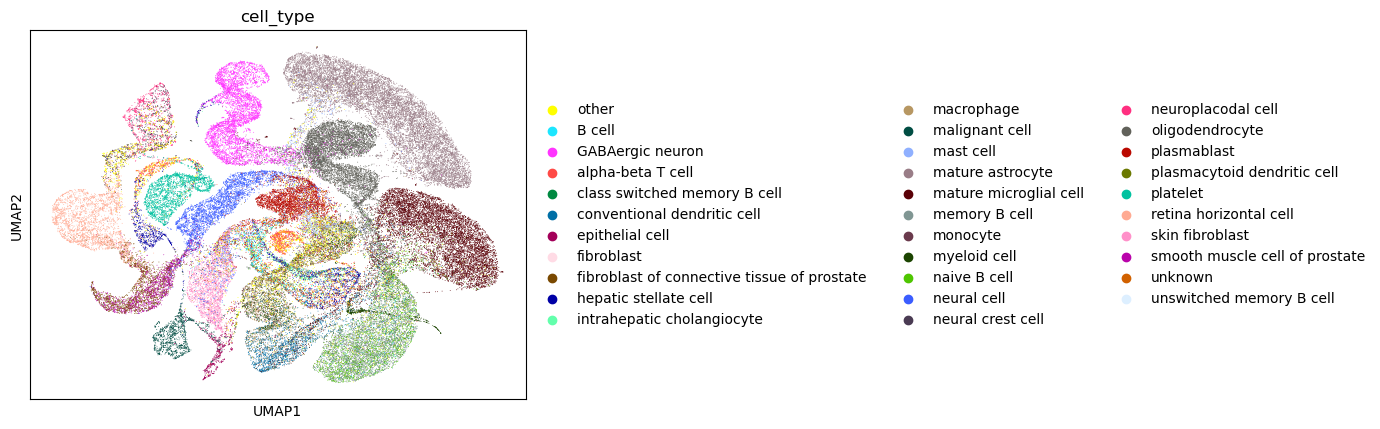

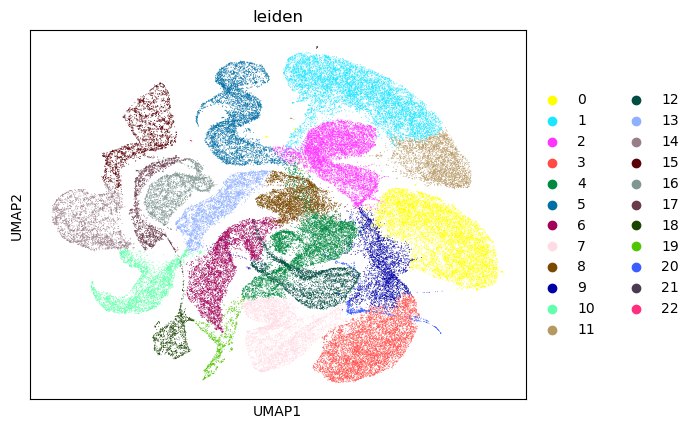

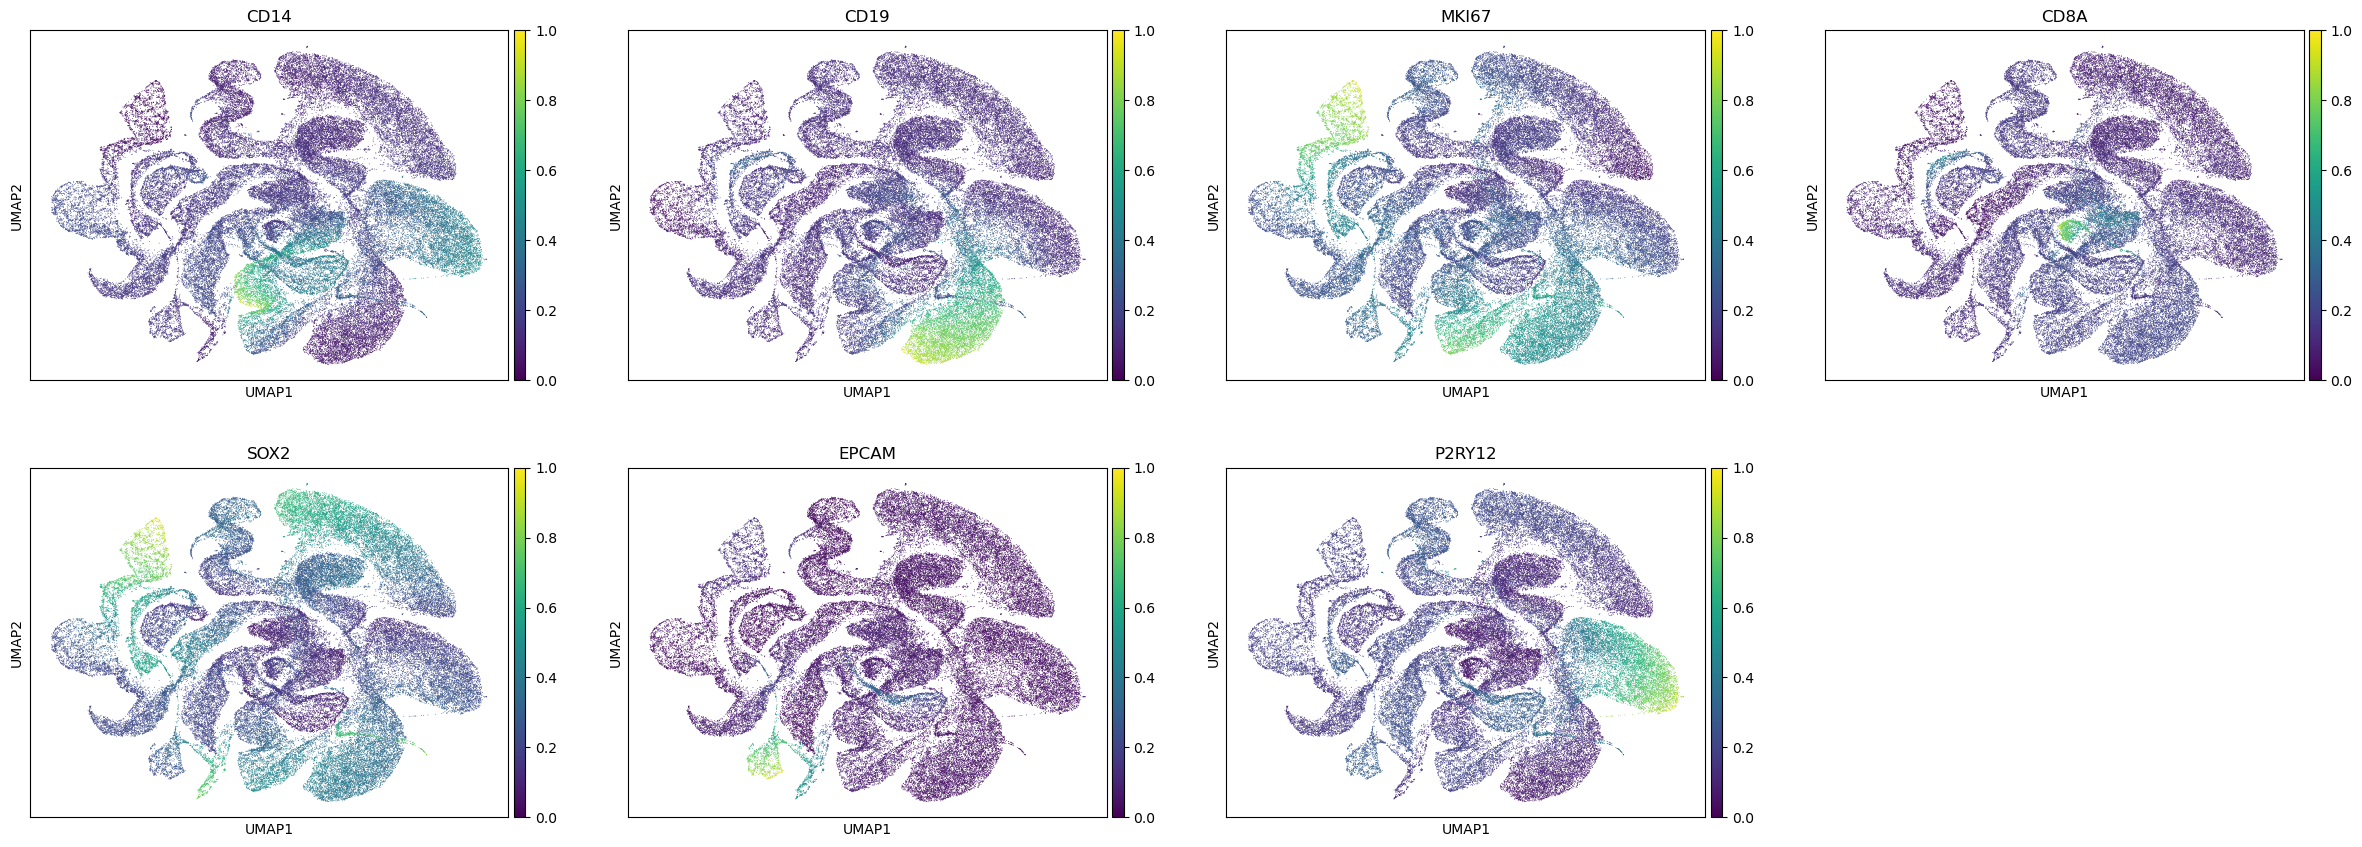

In [ ]:
recon_obj = scNET.apply_on_full_object(obj, "cellXgene", human_flag=True, batch_size=1500)
sc.pl.umap(recon_obj, color=["cell_type"],color_map="tab20",layer="embeddings")
sc.pl.umap(recon_obj, color=["leiden"],color_map="tab20",layer="embeddings")
sc.pl.umap(recon_obj, color=["CD14","CD19","MKI67","CD8A","SOX2","EPCAM","P2RY12"])